In [37]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import cross_validation, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

men_color = 'blue'
women_color = 'magenta'

##############################
# for re-running notebook...
filter_by_thresh = True
##############################


readable_cols = ['actor','bday','movie','release','adjusted_gross',
                 'production_budget','age_on_release','male_txt','roi']



In [3]:
actor_full = pd.read_pickle('joint_df.pickle')
actor_data = actor_full.drop(['rank','unadjusted_gross','actor_id'], axis=1)

# drop the NaN's
pre_drop_nans = len(actor_data)
actor_data.dropna(inplace=True)
print'Dropped %i rows with NaNs. There are %i left.' % (pre_drop_nans-len(actor_data), len(actor_data))
print '\n* * *\n'

# will this inverse female_txt feature be useful? ***NO***
# it does not affect the model with all the wikipedia category boolean features
# it does not affect the simple model that uses only actor_data[['bday','age_on_release','male_txt']]
# it does not affect the polynomial model with 
#     poly_features = ['bday','age_on_release','release','male_txt','female_txt']
# actor_data['female_txt'] = 1 - actor_data.male_txt

# convert times to yearly
secs_per_year = 31622400.0
actor_data.age_on_release = actor_data.age_on_release.dt.total_seconds()/secs_per_year

for col in ['bday']:
    actor_data[col] = actor_data[col].dt.year

# calculate crude ROI
actor_data['roi'] = (actor_data.domestic_gross - actor_data.production_budget) / actor_data.production_budget

Dropped 0 rows with NaNs. There are 9342 left.

* * *



In [4]:
# set movies_count for each actor
actor_data.set_index('actor', inplace=True)
actor_data['movies_count'] = actor_data.reset_index().groupby('actor').movie.apply(pd.Series.count)

actor_data.reset_index(inplace=True)
# actor_data[readable_cols].head(10)

In [133]:
for color, gender, is_male, bins in zip((men_color, women_color),('male','female'),(1,0),(20,10)):
    actor_data[actor_data.male_txt == is_male].reset_index().groupby('actor').movies_count.first().plot.hist(
        title='Count of Movies per actor (before filtering)', bins=bins, color=color, alpha=0.8, label=gender);
plt.legend()

NameError: name 'actor_data' is not defined

In [6]:
# Set filtering thresholds
roi_threshold = 4
age_min_thresh = 16
age_max_thresh = 65
current_year = 2016

movie_count_thresh = 10

if filter_by_thresh:

    # filter out crazy erroneous stuff by eye,
    # looking at pre-filtered scatterplots
    pre_filter_len = len(actor_data)
    actor_data = actor_data[
        (actor_data.bday < current_year-age_min_thresh) & (actor_data.bday > current_year-age_max_thresh) & 
    #     (age_min_thresh <= actor_data.age_on_release) & (actor_data.age_on_release <= age_max_thresh) & 
        (1980 <= actor_data.release) & (actor_data.release <= 2015) &
        (actor_data.roi < roi_threshold)]

    print'Filtered out %i rows with values out of range. There are %i rows left.' % (
        pre_filter_len-len(actor_data), len(actor_data))
    print '\n* * *\n\n'
else:
    print 'DID NOT FILTER!!!'
# actor_data[readable_cols].head()

Filtered out 2024 rows with values out of range. There are 7318 rows left.

* * *




26


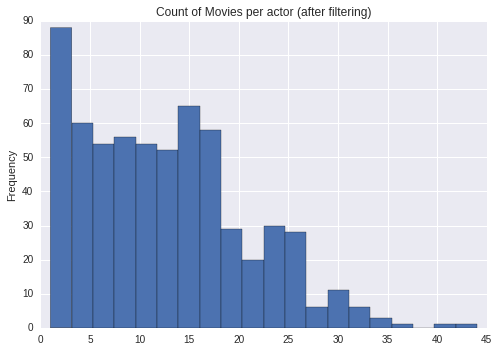

In [7]:
print actor_data[actor_data.actor == 'Jonah Hill'].movies_count.iloc[0]

actor_data.reset_index().groupby('actor').movies_count.first().plot.hist(
    title='Count of Movies per actor (after filtering)', bins=20);

In [8]:
# only include actors with over N movies (less than would not give enough data to be useful)
pre_filter_len = len(actor_data)
actor_data = actor_data[actor_data.movies_count > movie_count_thresh]
print 'removed %i roles, %i left' % (pre_filter_len-len(actor_data), len(actor_data))

removed 1443 roles, 5875 left


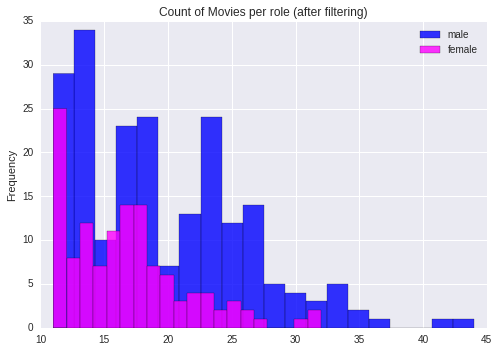

In [9]:
for color, gender, is_male in zip((men_color, women_color),('male','female'),(1,0)):
    actor_data[actor_data.male_txt == is_male].reset_index().groupby('actor').movies_count.first().plot.hist(
        title='Count of Movies per role (after filtering)', bins=20, color=color, alpha=0.8, label=gender);
plt.legend()

In [10]:
# drop the text columns (except for actor)
actor_data.drop(['movie','studio'], axis=1, inplace=True)

# keep only the int-formatted release year, 'release'
actor_data.drop(['release_day','release_date'], axis=1, inplace=True)

# # convert datetime/timedelta to numeric
# for col in actor_data.select_dtypes(exclude=['bool']).columns:
#     print '(before)', col, '\t\t', actor_data[col].dtype
#     actor_data[col] = pd.to_numeric(actor_data[col])
#     print '(after )', col, '\t\t', actor_data[col].dtype, '\n'

# actor_data.head()

In [11]:
# actor_data.to_pickle('actor_data_cleaned.pickle')

# Done cleaning data. Start modeling.

In [12]:
dependent_var = 'roi'

In [13]:
# The convenience fn train_test_split() randomly splits X and y into train and test.
# For results to be reproducible, set the random seed

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data[dependent_var],
    test_size=0.3, 
    random_state=0)

print 'Attempting to predict y="%s"\n\n' % y_train.name

non_bool_columns = [col for col in X_train.columns if X_train[col].dtype != 'bool']

# look at all the non-bool features
print 'non-bool features in X:\n'
for col in non_bool_columns:
    print col, '\t', X_train[col].dtype

print '\n\nthey look like:\n'
X_train[non_bool_columns].head()

Attempting to predict y="roi"


non-bool features in X:

release 	int64
bday 	int64
male_txt 	float64
age_on_release 	float64
movies_count 	int64


they look like:



,release,bday,male_txt,age_on_release,movies_count
3378,2006,1964,0,42.128415,22
4106,2003,1952,1,51.311475,33
97,2001,1955,1,46.005464,24
3282,2003,1953,1,49.816940,25
2726,1998,1962,1,36.090164,17


In [14]:
lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=6000)
lasso_model.fit(X_train, y_train)

/home/ian/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=6000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [15]:
def make_coef_df(model, X_train, y_train, significance_thresh=0):
    print 'alpha (aka lambda) for model: %f' % model.alpha_
    print 'intercept for model: %f' % model.intercept_
    print 'R-squared (unadjusted??) of model on training set:', model.score(X_train, y_train)

    significant_columns = np.where(abs(model.coef_) > significance_thresh)[0]
    
    print '\ngot %i significant columns (abs is > %f) out of %i' % (
        len(significant_columns), significance_thresh, len(model.coef_))

    coef_df = pd.DataFrame(
        [(model.coef_[idx], X_train.columns[idx]) for idx in significant_columns], 
        index=significant_columns, columns=['coef','col_name'])

    # sort coefficients by absolute value
    coef_df = coef_df.loc[coef_df.coef.abs().sort_values(ascending=False).index]
    return coef_df

In [16]:
# top 20
coef_df = make_coef_df(lasso_model, X_train, y_train)
coef_df.head(20)

alpha (aka lambda) for model: 0.000529
intercept for model: 8.190814
R-squared (unadjusted??) of model on training set: 0.0297054178527

got 23 significant columns (abs is > 0.000000) out of 344


,coef,col_name
271,0.271608,American women comedians
191,0.222778,African-American actresses
168,0.214750,All Wikipedia articles written in Canadian Eng...
115,0.171513,African-American male actors
174,0.098559,American male comedians
108,0.094738,American feminists
316,-0.086215,20th-century English actresses
297,0.064720,American television writers
205,-0.047463,1968 births
177,0.030988,Actresses from New York City


In [17]:
for interest in ['People from Manhattan'] + non_bool_columns:
    idx = X_train.columns.get_loc(interest)
    print lasso_model.coef_[idx], interest

0.0 People from Manhattan
-0.00388679071711 release
0.0 bday
-0.0 male_txt
-0.00391614901174 age_on_release
0.0 movies_count


In [18]:
# my columns of interest, besides those bools
coef_df[coef_df.col_name.isin(non_bool_columns)]

,coef,col_name
342,-0.003916,age_on_release
0,-0.003887,release


In [19]:
# most positive betas
coef_df.sort_values('coef', ascending=False).head(10)

,coef,col_name
271,0.271608,American women comedians
191,0.222778,African-American actresses
168,0.214750,All Wikipedia articles written in Canadian Eng...
115,0.171513,African-American male actors
174,0.098559,American male comedians
108,0.094738,American feminists
297,0.064720,American television writers
177,0.030988,Actresses from New York City
121,0.018276,American television producers
304,0.013787,American people of Irish descent


In [20]:
# most negative betas
coef_df.sort_values('coef').head(10)

,coef,col_name
316,-0.086215,20th-century English actresses
205,-0.047463,1968 births
309,-0.021391,César Award winners
289,-0.019087,English male film actors
184,-0.011032,HIV/AIDS activists
195,-0.008969,Silver Bear for Best Actress winners
342,-0.003916,age_on_release
0,-0.003887,release
183,-0.002331,Official website different in Wikidata and Wik...
100,0.001612,American people of English descent


# Try a much simpler model

In [21]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data[['bday','age_on_release','male_txt']], 
    actor_data[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

alpha (aka lambda) for model: 0.000001
intercept for model: 16.239443
R-squared (unadjusted??) of model on training set: 0.00769532042301

got 3 significant columns (abs is > 0.000000) out of 3


,coef,col_name
1,-0.013921,age_on_release
2,-0.013906,male_txt
0,-0.007838,bday


# Exploratory plots

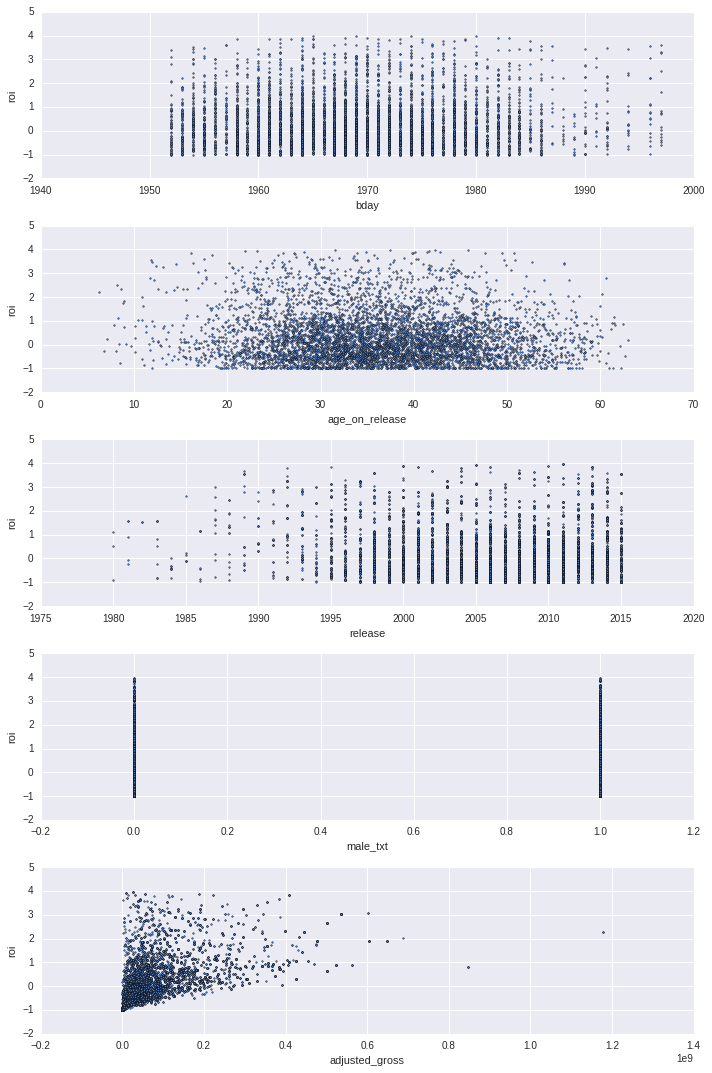

In [22]:
cols_to_plot = ['bday','age_on_release','release','male_txt','adjusted_gross']

plt.figure(figsize=(10,15))

for idx, col in enumerate(cols_to_plot):
    ax = plt.subplot(len(cols_to_plot),1,idx+1)
    plt.xlabel(col)
    actor_data.plot.scatter(col, dependent_var, ax=ax, s=3)
    
plt.tight_layout()

# Warning: these plots are by movie-and-actor rows. A given movie and actor will have multiple rows. They should probably be grouped first...

Count: 3892 males, 1983 females
Male   mean adj gross: 91274244
Female mean adj gross: 80197518
men gross 11076726 more than women (diff of means)


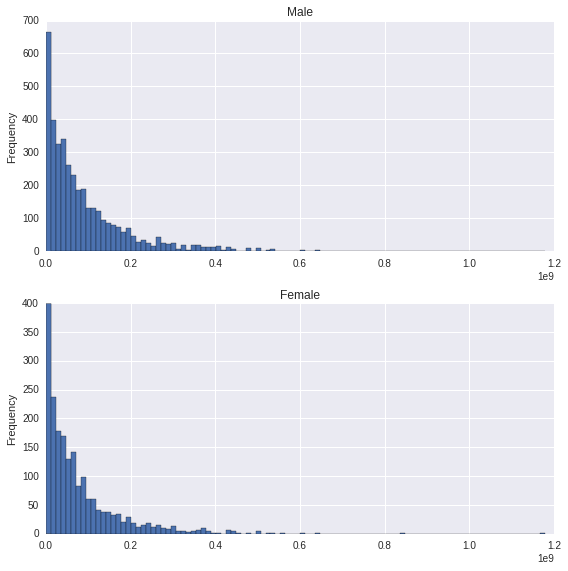

In [23]:
no_bins = 100
plt.figure(figsize=(8,8))

males_adj_gross = actor_data[actor_data.male_txt==1]['adjusted_gross']
females_adj_gross = actor_data[actor_data.male_txt==0]['adjusted_gross']

print 'Count: %i males, %i females' % (len(males_adj_gross), len(females_adj_gross))
print 'Male   mean adj gross: %i\nFemale mean adj gross: %i' % (males_adj_gross.mean(), females_adj_gross.mean())
print 'men gross %i more than women (diff of means)' % (males_adj_gross.mean() - females_adj_gross.mean())
ax = plt.subplot(2,1,1)
males_adj_gross.plot.hist(bins=no_bins, title='Male')

ax = plt.subplot(2,1,2)
females_adj_gross.plot.hist(bins=no_bins, ax=ax, title='Female')

plt.tight_layout()

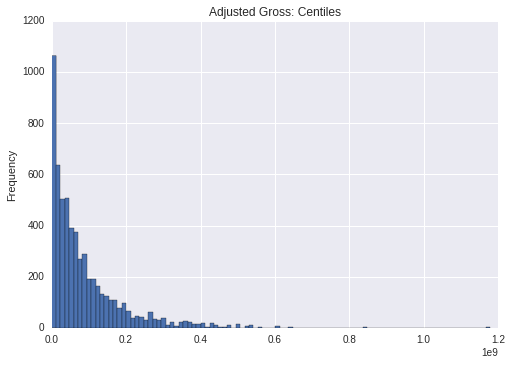

In [24]:
actor_data.adjusted_gross.plot.hist(bins=100)
plt.title('Adjusted Gross: Centiles');

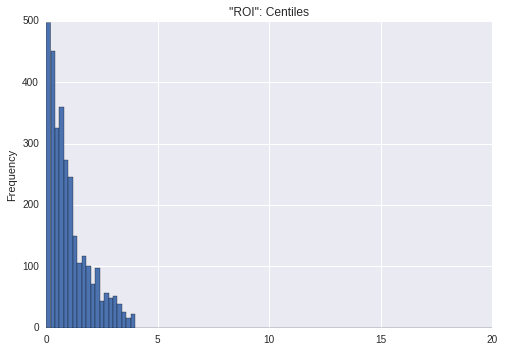

In [25]:
actor_data.roi.plot.hist(bins=100, range=(0,20))
plt.title('"ROI": Centiles');

min:6
max:62
mean:36


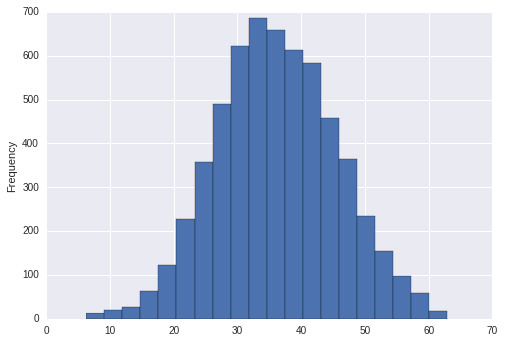

In [26]:
print 'min:%i\nmax:%i\nmean:%i' % (
    actor_data.age_on_release.min(), actor_data.age_on_release.max(), actor_data.age_on_release.mean())

actor_data.age_on_release.plot.hist(bins=20);

1983 women in dataset after filtering
3892 men in dataset after filtering
1.962683 x  more men in the dataset
* * * 
women median age on movie release 32
men median age on movie release  37
* * * 
women mean age on movie release 32
men mean age on movie release  37



Distribution of actor ages on movie release date by gender


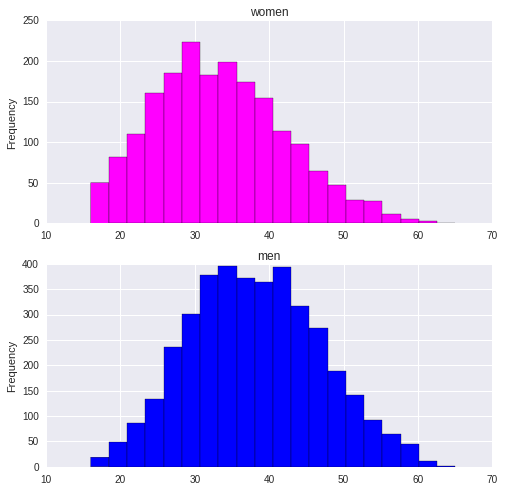

In [27]:
women = actor_data[actor_data.male_txt == 0].age_on_release
men = actor_data[actor_data.male_txt == 1].age_on_release

print '%i women in dataset after filtering' % len(women)
print '%i men in dataset after filtering' % len(men)
print '%f x  more men in the dataset' % (len(men)/(1.0*len(women)))
print '* '*3
print 'women median age on movie release %i\nmen median age on movie release  %i' % (women.median(), men.median())
print '* '*3
print 'women mean age on movie release %i\nmen mean age on movie release  %i' % (women.mean(), men.mean())
print '\n\n'
print 'Distribution of actor ages on movie release date by gender'

hist_bins = 20

plt.figure(figsize=(8,8))
ax = plt.subplot(2,1,1)
women.plot.hist(bins=hist_bins, ax=ax, title='women', color=women_color, range=[age_min_thresh,age_max_thresh])
ax = plt.subplot(2,1,2)
men.plot.hist(bins=hist_bins, ax=ax, title='men', color=men_color, range=[age_min_thresh,age_max_thresh]);

**Try polynomial features on age/date**

In [28]:
def plot_age_curve(actor_names, figsize=(10,10), y='production_budget'):
    """df is a dataframe with actor data, indexed by actor name"""
    plt.figure(figsize=figsize)
    
    if isinstance(actor_names, str):
        actor_names = [actor_names]
    
    actor_df = actor_data.set_index('actor')
    
    for idx, actor_name in enumerate(actor_names):
        ax = plt.subplot(len(actor_names), 1, idx+1)
        fig = actor_df.loc[actor_name].groupby('age_on_release', as_index=False).sum().plot(
            x='age_on_release', y=y, title=actor_name, ax=ax)
    
    return ax

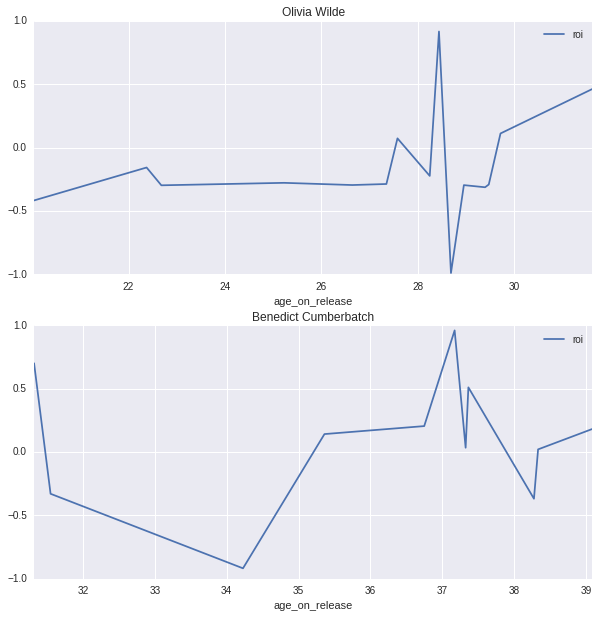

In [65]:
# selected_mf_actors = ['Helen Mirren','Bill Murray']
selected_mf_actors = ['Olivia Wilde','Benedict Cumberbatch']
plot_age_curve(selected_mf_actors, y='roi');

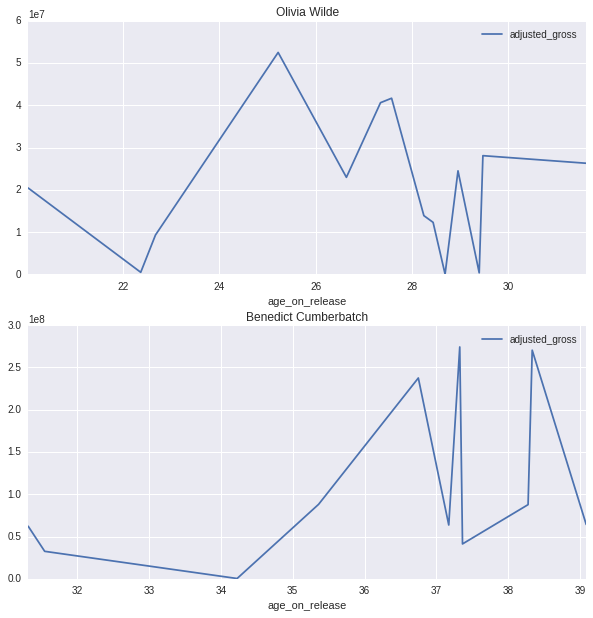

In [66]:
plot_age_curve(selected_mf_actors, y='adjusted_gross');

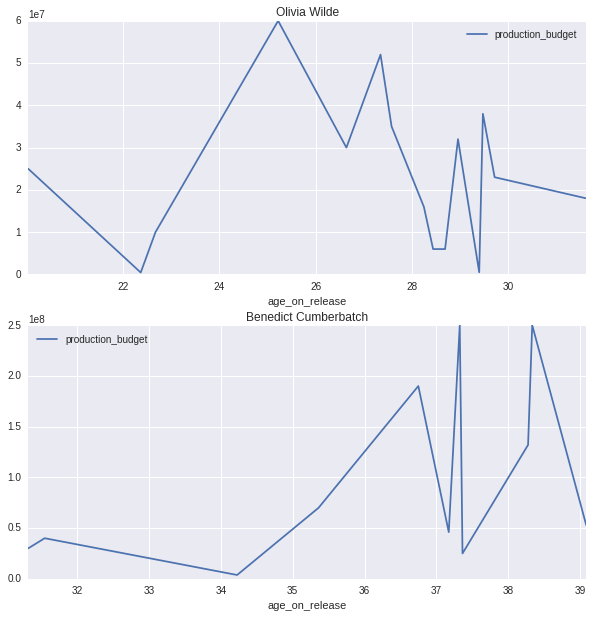

In [67]:
plot_age_curve(selected_mf_actors, y='production_budget');

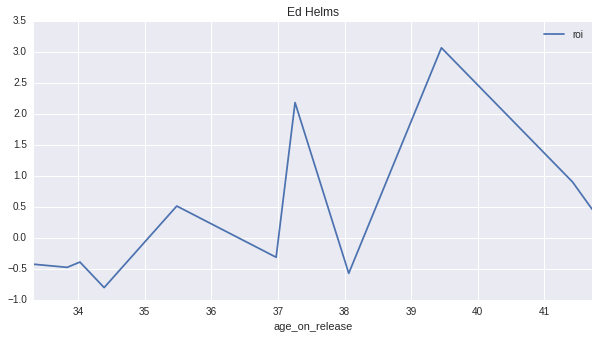

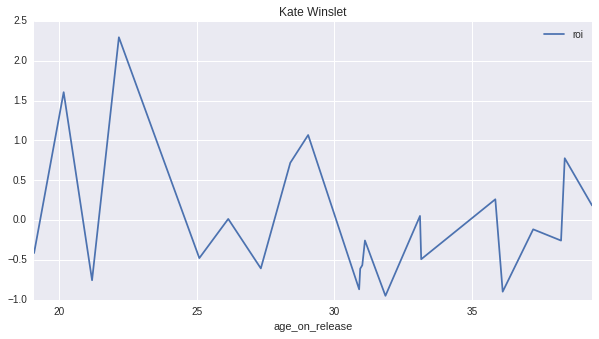

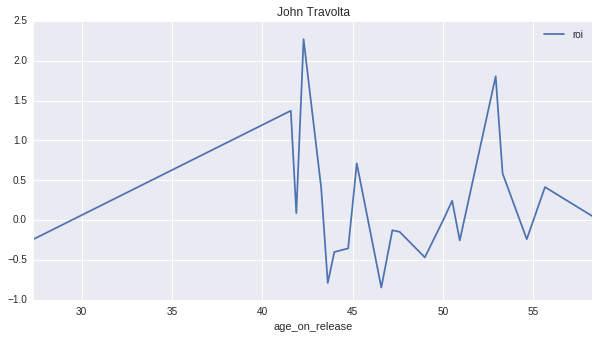

In [32]:
# plot some random age curves
for name in np.random.choice(actor_data.actor.unique(), size=3, replace=False):
    plot_age_curve(name, figsize=(10,5), y='roi')

# Polynomial model of selected non-category features

In [33]:
poly_features = ['bday','age_on_release','release','male_txt']

X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(
    actor_data[poly_features], 
    actor_data.production_budget, 
    test_size=0.3, 
    random_state=0)

poly_lasso = make_pipeline(PolynomialFeatures(), 
    linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=8000))

poly_lasso.fit(X_train3, y_train3)

lasso3 = poly_lasso.get_params()['lassocv']
poly_feat3 = poly_lasso.get_params()['polynomialfeatures']

print lasso3.coef_
print poly_feat3.powers_

[  0.00000000e+00  -0.00000000e+00   0.00000000e+00   1.35643576e+06
   0.00000000e+00  -0.00000000e+00   1.16608777e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.08196743e+05
   3.27426383e+01   0.00000000e+00   0.00000000e+00]
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]]


In [34]:
def get_poly_labels(labels, poly_obj):
    final_labels = []
    separator = '_x_'
    for power_list in poly_obj.powers_:
        s = ''
        for label, power in zip(labels, power_list):
            if power != 0:
                s += "%s_p%i%s" % (label, power, separator)
        if s == '':
            final_labels.append('1')
        else:
            final_labels.append(s[:-len(separator)])
    
    return final_labels
        
poly_labels = get_poly_labels(poly_features, poly_feat3)
pd.DataFrame(zip(poly_labels, list(lasso3.coef_)), columns=['feature','coef']).sort_values('coef', ascending=False)

,feature,coef
3,release_p1,1356435.755102
11,age_on_release_p1_x_male_txt_p1,208196.743302
6,bday_p1_x_age_on_release_p1,116.608777
12,release_p2,32.742638
0,1,0.000000
1,bday_p1,-0.000000
2,age_on_release_p1,0.000000
4,male_txt_p1,0.000000
5,bday_p2,-0.000000
7,bday_p1_x_release_p1,0.000000


In [35]:
print 'R-squared score:'
poly_lasso.score(X_train3, y_train3)

R-squared score:


0.062362024728206962

From the coefficients above, it looks like these combined features are useful:

```
age_on_release * male_txt
age_on_release^2
bday * male_txt
```

So I'll manually generate them:

In [36]:
actor_data_eng = actor_data.copy()

actor_data_eng['age_on_release_x_male_txt'] = actor_data_eng.age_on_release * actor_data_eng.male_txt
actor_data_eng['age_on_release_p2'] = actor_data_eng.age_on_release**2
actor_data_eng['bday_x_male_txt'] = actor_data_eng.bday * actor_data_eng.male_txt

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data_eng.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data_eng[dependent_var],
    test_size=0.3, 
    random_state=0)

print len(X_train), len(X_test)
print '\n\n Features:\n'
print [col for col in X_train.columns if X_train[col].dtype != 'bool']
print '\nBools\n'
print '<uncomment to print>'
# print [col for col in X_train.columns if X_train[col].dtype == 'bool']

y_train.head()

4112 1763


 Features:

['release', 'bday', 'male_txt', 'age_on_release', 'movies_count', 'age_on_release_x_male_txt', 'age_on_release_p2', 'bday_x_male_txt']

Bools

<uncomment to print>


3378   -0.911436
4106    0.321606
97     -0.746151
3282    0.861831
2726    0.089136
Name: roi, dtype: float64

In [37]:
lasso_model_eng = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=3000)
lasso_model_eng.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=3000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [38]:
coef_df_eng = make_coef_df(lasso_model_eng, X_train, y_train, significance_thresh=0)
coef_df_eng.head(20)

alpha (aka lambda) for model: 0.000529
intercept for model: 8.190814
R-squared (unadjusted??) of model on training set: 0.0297054178527

got 23 significant columns (abs is > 0.000000) out of 347


,coef,col_name
271,0.271608,American women comedians
191,0.222778,African-American actresses
168,0.214750,All Wikipedia articles written in Canadian Eng...
115,0.171513,African-American male actors
174,0.098559,American male comedians
108,0.094738,American feminists
316,-0.086215,20th-century English actresses
297,0.064720,American television writers
205,-0.047463,1968 births
177,0.030988,Actresses from New York City


# General women vs men budget:age curves (averaged across age)

Using each age as a whole number, compute the median production budget at that age for the given gender.

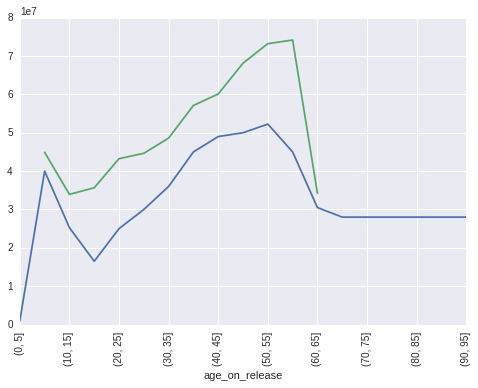

In [39]:
men = actor_data[actor_data.male_txt == 1].copy()
women = actor_data[actor_data.male_txt == 0].copy()

# Set to 5 for 5-year age bins
age_res = 5

for df in [men, women]:
    df.age_on_release = df.age_on_release.astype(int)
    df.age_on_release = pd.cut(x=df.age_on_release, bins=range(0,100,age_res))

def plot_overall_age_curve(df, how):
    if how == 'median':
        return df.groupby('age_on_release').median().production_budget.plot(rot=90)
    if how == 'mean':
        return df.groupby('age_on_release').mean().production_budget.plot(rot=90)
    
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(men, 'mean')

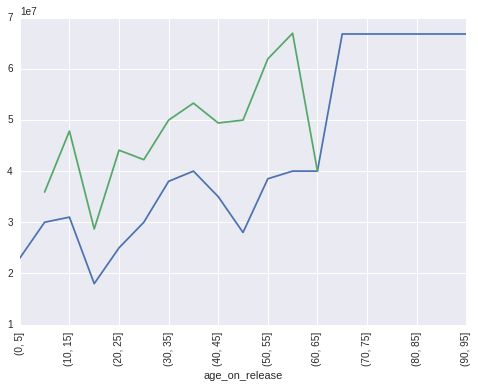

In [40]:
plot_overall_age_curve(women, 'median')
plot_overall_age_curve(women, 'mean')

Compare median of women and men

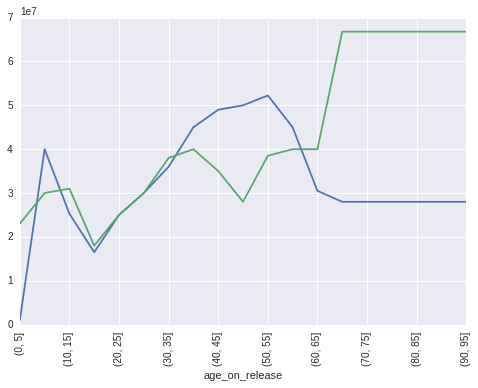

In [41]:
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(women, 'median')

# Simple scatterplot: "ROI" vs age_on_release

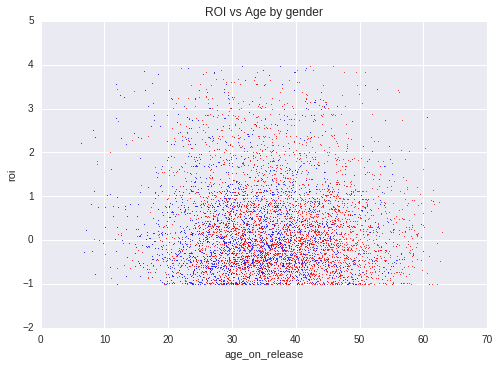

In [42]:
# reset vars
men = actor_data[actor_data.male_txt == 1].copy()
women = actor_data[actor_data.male_txt == 0].copy()

roi_age_title = 'ROI vs Age by gender'
fig, ax = plt.subplots()

for color, df in zip(('r','b'), (men, women)):
    df.plot.scatter('age_on_release','roi', title=roi_age_title, s=1, ax=ax, color=color, lw=0)
    
# if we look at all ROIs, the outlier make the graph illegible!

# Now I filtered this at the top...

In [43]:
# ROI threshold to drop outliers!
# roi_threshold = 10
print roi_threshold

4


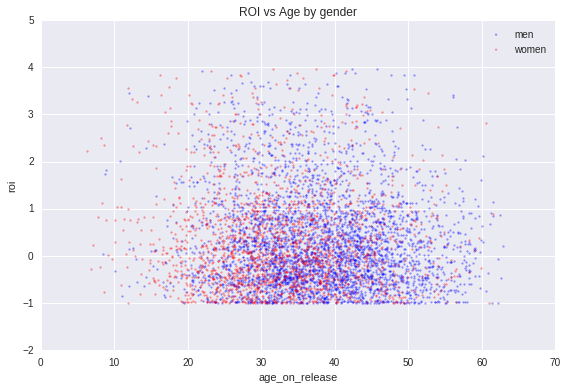

In [44]:
fig, ax = plt.subplots()

for color, df, label in zip((men_color,'r'), (men, women), ('men','women')):
    df[df.roi < roi_threshold].plot.scatter('age_on_release','roi', 
        title=roi_age_title, s=5, ax=ax, color=color, alpha=0.4, lw=0, label=label)
plt.tight_layout()

# Try the full-feature linear model with thresholded ROIs

## Update: I did this at the top of the notebook...

In [45]:
actor_data_thresh = actor_data[actor_data.roi < roi_threshold]

In [46]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data_thresh.drop(
        ['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data_thresh[dependent_var],
    test_size=0.3, 
    random_state=0)

lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000)
lasso_model.fit(X_train, y_train)

coef_df_eng = make_coef_df(lasso_model, X_train, y_train, significance_thresh=0)
coef_df_eng.head(20)

alpha (aka lambda) for model: 0.000529
intercept for model: 8.190814
R-squared (unadjusted??) of model on training set: 0.0297054178527

got 23 significant columns (abs is > 0.000000) out of 344


,coef,col_name
271,0.271608,American women comedians
191,0.222778,African-American actresses
168,0.214750,All Wikipedia articles written in Canadian Eng...
115,0.171513,African-American male actors
174,0.098559,American male comedians
108,0.094738,American feminists
316,-0.086215,20th-century English actresses
297,0.064720,American television writers
205,-0.047463,1968 births
177,0.030988,Actresses from New York City


# The simple model on the roi-thresholded data

In [47]:
print 'dependent_var is:%s\n' % dependent_var

X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data_thresh[['bday','age_on_release','male_txt']], 
    actor_data_thresh[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

dependent_var is:roi

alpha (aka lambda) for model: 0.000001
intercept for model: 16.239443
R-squared (unadjusted??) of model on training set: 0.00769532042301

got 3 significant columns (abs is > 0.000000) out of 3


,coef,col_name
1,-0.013921,age_on_release
2,-0.013906,male_txt
0,-0.007838,bday


In [48]:
print 'dependent_var is:%s\n' % dependent_var

X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data_thresh[['age_on_release','male_txt']], 
    actor_data_thresh[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

dependent_var is:roi

alpha (aka lambda) for model: 0.000053
intercept for model: 0.581054
R-squared (unadjusted??) of model on training set: 0.00581929109783

got 1 significant columns (abs is > 0.000000) out of 2


,coef,col_name
0,-0.007967,age_on_release


# Lasso with polynomials of rank 1, 2, or 3 on:

* age_on_release
* release
* male_txt

Note that birthday year should capture the same info as movie release year (eg decade trends), as long as you have `age_on_release`

In [49]:
def run_poly_lasso(degree, beta_thresh=0.000000000001):
    poly_features = ['age_on_release','release','male_txt']

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        actor_data[poly_features], 
        actor_data[dependent_var], 
        test_size=0.3, 
        random_state=0)

    poly_lasso = make_pipeline(PolynomialFeatures(degree=degree), 
        linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=8000))

    poly_lasso.fit(X_train, y_train)

    lasso = poly_lasso.get_params()['lassocv']
    poly_feat = poly_lasso.get_params()['polynomialfeatures']

    print 'DEGREE: %i' % degree
    print 'Intercept: %f' % lasso.intercept_
    print 'Train score R-squared: %f' % poly_lasso.score(X_train, y_train)

    poly_labels = get_poly_labels(poly_features, poly_feat)
    
    report_df = pd.DataFrame(
        zip(poly_labels, list(lasso.coef_)), columns=['feature','coef'])
    
    # sort by abs val of betas
    report_df = report_df.reindex(report_df.coef.abs().sort_values(ascending=False).index)
    # filter out betas with abs vals below thresh
    pre_filtered_len = len(report_df)
    report_df = report_df[report_df.coef.abs() >= beta_thresh]
    print '\n\nFiltered out %i betas: abs(B)<%f.\n%i remain.' % (
        pre_filtered_len-len(report_df), beta_thresh, len(report_df))
    
    return report_df

In [50]:
run_poly_lasso(degree=3)

DEGREE: 3
Intercept: 337.119493
Train score R-squared: 0.010388


Filtered out 7 betas: abs(B)<0.000000.
13 remain.


,feature,coef
2,release_p1,-2.539258e-01
1,age_on_release_p1,-9.633364e-02
6,age_on_release_p1_x_male_txt_p1,1.174354e-02
4,age_on_release_p2,2.973793e-04
12,age_on_release_p2_x_male_txt_p1,-2.501927e-04
10,age_on_release_p3,-1.033858e-05
5,age_on_release_p1_x_release_p1,9.321206e-06
7,release_p2,7.203523e-06
14,age_on_release_p1_x_release_p1_x_male_txt_p1,1.842634e-06
11,age_on_release_p2_x_release_p1,5.779586e-07


In [51]:
run_poly_lasso(degree=2)

DEGREE: 2
Intercept: 62.955676
Train score R-squared: 0.008398


Filtered out 3 betas: abs(B)<0.000000.
7 remain.


,feature,coef
2,release_p1,-0.053938
3,male_txt_p1,0.037149
1,age_on_release_p1,-0.020297
9,male_txt_p2,0.009612
6,age_on_release_p1_x_male_txt_p1,-0.001666
4,age_on_release_p2,0.000211
7,release_p2,0.000011


In [52]:
run_poly_lasso(degree=1)

DEGREE: 1
Intercept: 16.380179
Train score R-squared: 0.007722


Filtered out 1 betas: abs(B)<0.000000.
3 remain.


,feature,coef
3,male_txt_p1,-0.013777
2,release_p1,-0.007909
1,age_on_release_p1,-0.006033


In [53]:
run_poly_lasso(degree=4)

DEGREE: 4
Intercept: 579.535396
Train score R-squared: 0.011629


Filtered out 18 betas: abs(B)<0.000000.
17 remain.


,feature,coef
2,release_p1,-3.999359e-01
1,age_on_release_p1,-1.062735e-01
6,age_on_release_p1_x_male_txt_p1,1.718477e-02
25,age_on_release_p2_x_male_txt_p2,-3.703312e-04
5,age_on_release_p1_x_release_p1,9.852921e-06
22,age_on_release_p3_x_male_txt_p1,1.662158e-06
11,age_on_release_p2_x_release_p1,2.357984e-07
20,age_on_release_p4,-8.095293e-08
17,release_p2_x_male_txt_p1,-4.775798e-08
24,age_on_release_p2_x_release_p1_x_male_txt_p1,-2.551466e-08


# Try model specification with dmatrices

In [54]:
import patsy

y, X = patsy.dmatrices('roi ~ (age_on_release + release + pow(age_on_release,2) + pow(release,2)) * male_txt', 
    data=actor_data , return_type='dataframe')

for col in X.columns:
    print col

Intercept
age_on_release
release
pow(age_on_release, 2)
pow(release, 2)
male_txt
age_on_release:male_txt
release:male_txt
pow(age_on_release, 2):male_txt
pow(release, 2):male_txt


In [55]:
def run_lasso(X, y):
    """
    Convenience wrapper to make a lasso. Use like:
    >>> my_lasso, X_train, X_test, y_train, y_test = run_lasso(X, y)
    
    Then to see the coefficients do:
    >> make_coef_df(my_lasso, X_train, y_train, significance_thresh=0)
    """

    # note that I do y.values.ravel() to avoid a weird sklearn error which I don't understand...
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y.values.ravel(), 
        test_size=0.3, random_state=0)

    lasso = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000)

    lasso.fit(X_train, y_train)

    print 'Intercept: %f' % lasso.intercept_
    print 'Train score R-squared: %f' % lasso.score(X_train, y_train)
        
    return lasso, X_train, X_test, y_train, y_test

In [56]:
patsy_poly_lasso, X_train, X_test, y_train, y_test = run_lasso(X, y)

Intercept: 44.679705
Train score R-squared: 0.008895


In [57]:
make_coef_df(patsy_poly_lasso, X_train, y_train, significance_thresh=-1)

alpha (aka lambda) for model: 0.000001
intercept for model: 44.679705
R-squared (unadjusted??) of model on training set: 0.00889474427341

got 10 significant columns (abs is > -1.000000) out of 10


,coef,col_name
2,-3.556402e-02,release
1,-3.457751e-02,age_on_release
6,2.349368e-02,age_on_release:male_txt
3,4.286414e-04,"pow(age_on_release, 2)"
8,-3.603324e-04,"pow(age_on_release, 2):male_txt"
7,-1.265423e-04,release:male_txt
4,6.862466e-06,"pow(release, 2)"
9,-2.739908e-08,"pow(release, 2):male_txt"
5,-0.000000e+00,male_txt
0,0.000000e+00,Intercept


## Now use these features in a plain old OLS model

Get rid of everything but the most significant columns in the lasso results.

In [58]:
import statsmodels.api as sm

# Do train-test split
train_data, test_data = cross_validation.train_test_split(actor_data, test_size = 0.33)

# Generate train with patsy.dmatrices
y_train, X_train = patsy.dmatrices('roi ~ (age_on_release + pow(age_on_release,2))*male_txt + release + pow(release,2)', 
    data=train_data , return_type='dataframe')

ols_model = sm.OLS(y_train, X_train)
res = ols_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.676
Date:                Thu, 21 Apr 2016   Prob (F-statistic):           7.04e-08
Time:                        22:16:45   Log-Likelihood:                -5593.4
No. Observations:                3936   AIC:                         1.120e+04
Df Residuals:                    3928   BIC:                         1.125e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                        6192.9237   1269.375      4.879      0.000      3704.228  8681.620
age_on_release                     -0.0217      0.015     -1.441      0.150        -0.051     0.008
pow(age_on_release, 2)              0.0003      0.000      1.206      0.228        -0.000     0.001
male_txt                           -0.1907      0.364     -0.525      0.600        -0.904     0.522
age_on_release:male_txt             0.0156      0.021      0.753      0.451        -0.025     0.056
pow(age_on_release, 2):male_txt    -0.0003      0.000     -1.021      0.307        -0.001     0.000
release                            -6.1790      1.267     -4.876      0.000        -8.663    -3.695
pow(release, 2)                     0.0015      0.000      4.874      0.000         0.001     0.002
==============================================================================
Omnibus:                      631.948   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              994.992
Skew:                           1.114   Prob(JB):                    8.72e-217
Kurtosis:                       4.048   Cond. No.                     3.19e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
res.params

Intercept                          6192.923729
age_on_release                       -0.021676
pow(age_on_release, 2)                0.000270
male_txt                             -0.190747
age_on_release:male_txt               0.015569
pow(age_on_release, 2):male_txt      -0.000294
release                              -6.179009
pow(release, 2)                       0.001541
dtype: float64

In [60]:
def OLS_eqn(results):
    """Returns a string for the linear eqn based on statsmodels OLS model results."""
    eqn_vars = []
    for var_name, val in results.params.iteritems():
        # Ignore 'Intercept'
        if var_name == 'Intercept':
            eqn_vars.append(str(val))
        else:
            eqn_vars.append("{val}*{var_name}".format(
                var_name=var_name.replace(':',"*"), val=val))
    return 'y = ' + ' + '.join(eqn_vars)

def OLS_eqn_evalable(params, params_str_name):
    """copy-and-paste friendly version of your linear model equation"""
    eqn_vars = []
    for var, _ in params.iteritems():
        if var == 'Intercept':
            eqn_vars.append(params_str_name+'.Intercept')
        else:
            eqn_vars.append('{p}["{var_key}"] * {var}'.format(
                    p=params_str_name, var_key=var, var=var.replace(':',' * ')))
        
    return ' +\\\n '.join(eqn_vars)



evalable_OLS_eqn = OLS_eqn_evalable(res.params, 'res.params')

print OLS_eqn(res)
print '\n\n'
print evalable_OLS_eqn

y = 6192.92372937 + -0.0216758513533*age_on_release + 0.000270152871214*pow(age_on_release, 2) + -0.190746630951*male_txt + 0.0155687257932*age_on_release*male_txt + -0.000294454591837*pow(age_on_release, 2)*male_txt + -6.17900866898*release + 0.00154144587695*pow(release, 2)



res.params.Intercept +\
 res.params["age_on_release"] * age_on_release +\
 res.params["pow(age_on_release, 2)"] * pow(age_on_release, 2) +\
 res.params["male_txt"] * male_txt +\
 res.params["age_on_release:male_txt"] * age_on_release * male_txt +\
 res.params["pow(age_on_release, 2):male_txt"] * pow(age_on_release, 2) * male_txt +\
 res.params["release"] * release +\
 res.params["pow(release, 2)"] * pow(release, 2)


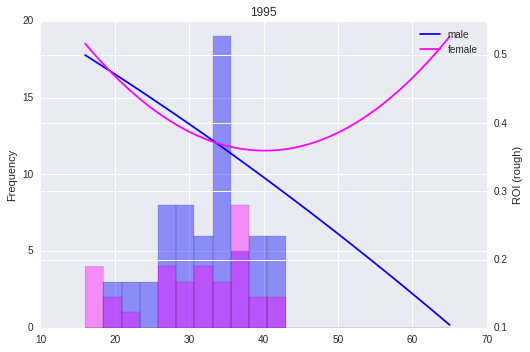

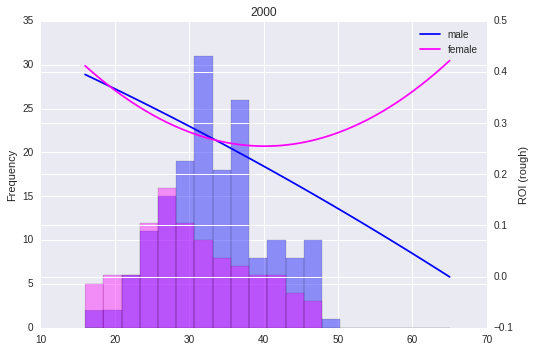

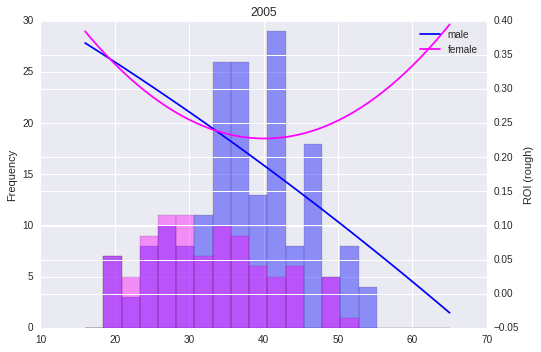

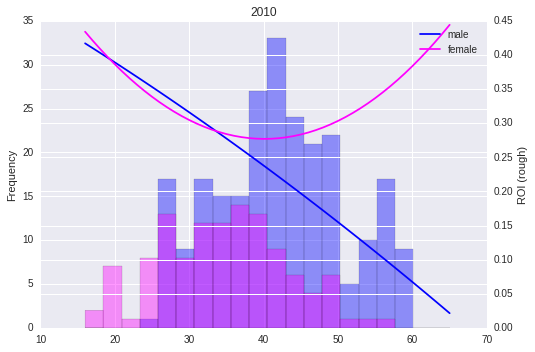

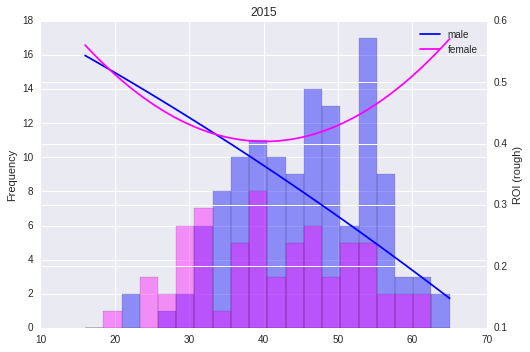

In [61]:
def plot_age_curve_eqns(age_curve_fn, res, male, release, 
    age_range=range(age_min_thresh, age_max_thresh+1), ax=None, addl_plt_args={}):
    
    #default x_range is 16-85 years old...
    if male:
        male_txt=1
        label = 'male'
    else:
        male_txt=0
        label = 'female'
        
    y = [age_curve_fn(age, male_txt, release) for age in age_range]
    
    plt.xlabel('age')
    plt.ylabel('ROI (rough)')
    if ax == None:
        fig =  plt.plot(age_range, y, label=label, **addl_plt_args)
    else:
        fig = ax.plot(age_range, y, label=label, **addl_plt_args)
    plt.legend()
    return fig

def age_curve_fn_1(age_on_release, male_txt, release):
    return res.params.Intercept +\
        res.params["age_on_release"] * age_on_release +\
        res.params["pow(age_on_release, 2)"] * pow(age_on_release, 2) +\
        res.params["male_txt"] * male_txt +\
        res.params["age_on_release:male_txt"] * age_on_release * male_txt +\
        res.params["pow(age_on_release, 2):male_txt"] * pow(age_on_release, 2) * male_txt +\
        res.params["release"] * release +\
        res.params["pow(release, 2)"] * pow(release, 2)
        
def plot_fns_across_years(plot_fn, years_to_plot):        
    for release_year_to_plot in years_to_plot:
        # set up twin axes
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        # histograms of actor_data age_on_release
        hist_alpha = 0.4

        actor_data[(actor_data.male_txt == 1) & (actor_data.release == release_year_to_plot)].age_on_release.plot.hist(
            bins=20, label='men', 
            range=[age_min_thresh,age_max_thresh], ax=ax1, alpha=hist_alpha, color=men_color);        
        
        actor_data[(actor_data.male_txt == 0) & (actor_data.release == release_year_to_plot)].age_on_release.plot.hist(
            bins=20, label='women', 
            range=[age_min_thresh,age_max_thresh], ax=ax1, alpha=hist_alpha, color=women_color)
        
        # curve of model function
        male_fig = plot_age_curve_eqns(plot_fn, res, male=True, 
            release=release_year_to_plot, ax=ax2, addl_plt_args={'color':men_color})
        female_fig = plot_age_curve_eqns(plot_fn, res, male=False, 
            release=release_year_to_plot, ax=ax2, addl_plt_args={'color':women_color})

        plt.title(release_year_to_plot)
        plt.show()

        
# years_to_plot=[1975,1980,1990,2000,2010,2012]
years_to_plot=[1995,2000,2005,2010,2015]
        
plot_fns_across_years(age_curve_fn_1, years_to_plot)

# WARNING: Results change drastically when you filter out the outliers

***

# How does age affect it alone?

d(roi)/d(age) curves for 95.000000% confidence interval


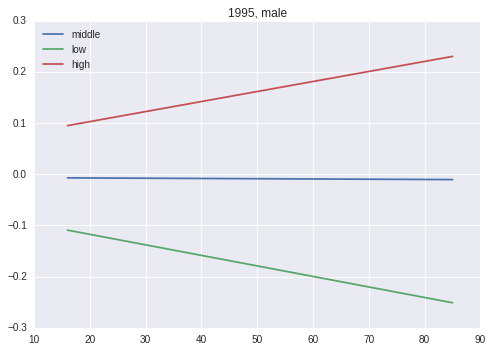

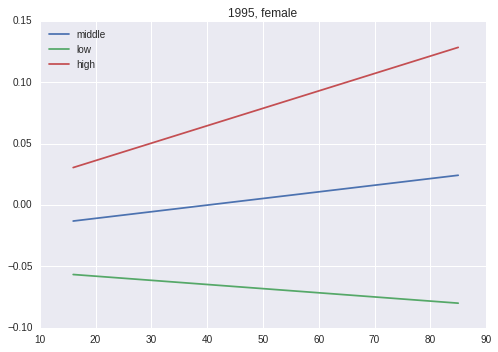

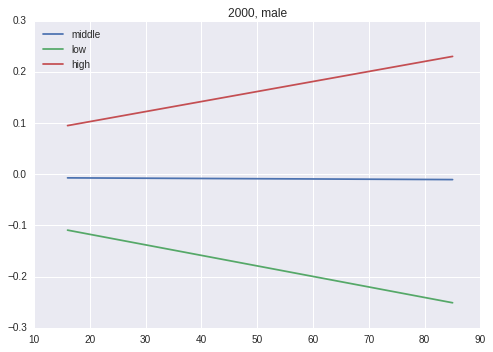

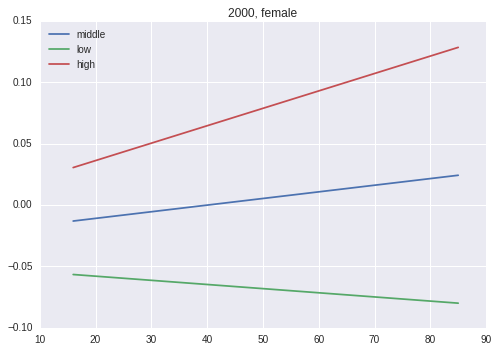

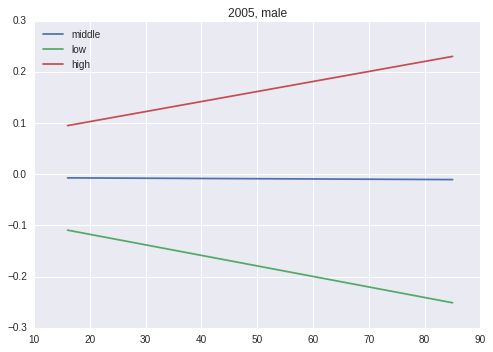

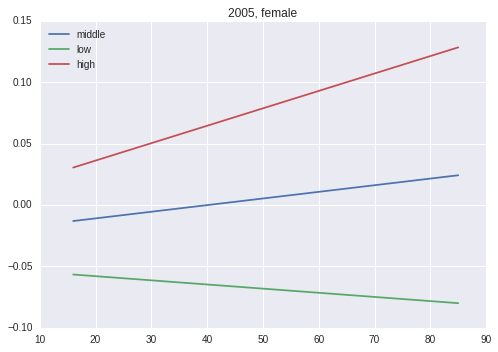

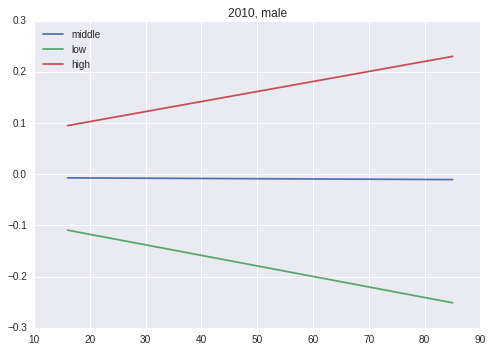

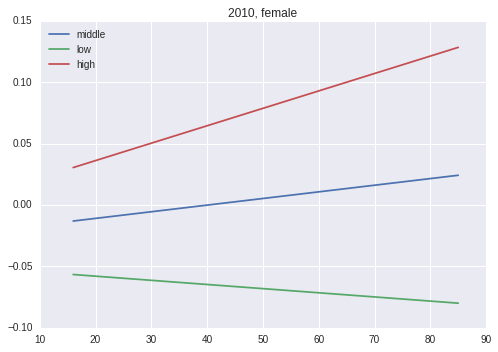

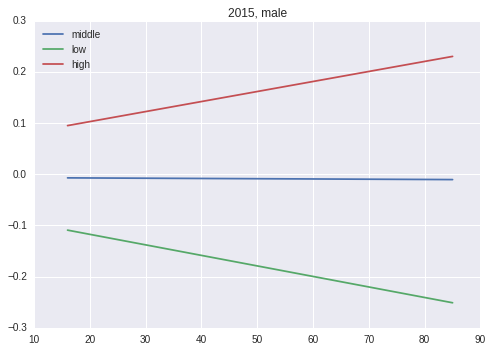

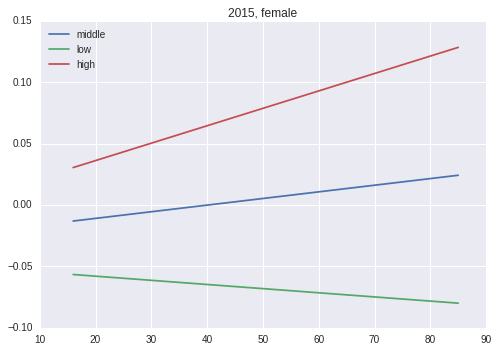

In [62]:
def plot_eqn(formula, x_range, label=None):  
    x = np.array(x_range)  
    y = formula(x)
    fig = plt.plot(x, y, label=label)
    return fig

def age_curve_fn_dy_dage(age_on_release, betas, male_txt):
    return \
        betas["age_on_release"] +\
        2 * betas["pow(age_on_release, 2)"] * age_on_release +\
        betas["age_on_release:male_txt"] * male_txt +\
        2 * betas["pow(age_on_release, 2):male_txt"] * age_on_release * male_txt

##################


conf_alpha = 1-0.95
print 'd(roi)/d(age) curves for %f%% confidence interval' % ((1-conf_alpha)*100.0)

conf_int_df = res.conf_int(alpha = conf_alpha)
conf_int_df.columns = ['low','high']

age_range=range(16,85+1)

for release_year_to_plot in years_to_plot:
    for title, male_plot in zip(['male','female'], [1,0]):
        for betaname, betas in zip(['middle','low','high'], [res.params, conf_int_df['low'], conf_int_df['high']]):
            fig = plot_eqn(lambda age: age_curve_fn_dy_dage(age, betas, male_txt=male_plot), age_range, label=betaname)
        plt.title('%s, %s' % (release_year_to_plot, title))
        plt.legend(loc='best')
        plt.show()


# What if we look at total number of movies over an actor's career instead?

In [81]:
actor_mojo_gross = pd.read_pickle('actor_mojo_gross.pickle')
actor_mojo_gross.shape

(782, 7)

In [117]:
# top 20 most-appearing actors
actor_mojo_gross.groupby('actor').first().sort_values('no_movies', ascending=False).head()

,rank,total_gross,no_movies,avg_gross,top_picture,top_gross
actor,,,,,,
Robert DeNiro,16,"$3,077.3",78,$39.5,Meet the Fockers,$279.3
Samuel L. Jackson,2,"$4,646.8",68,$68.3,The Avengers,$623.4
Liam Neeson,19,"$2,941.8",62,$47.4,The Phantom Menace,$474.5
Christopher Walken,105,"$1,834.0",60,$30.6,Wedding Crashers,$209.3
Bruce Willis,12,"$3,189.4",60,$53.2,Sixth Sense,$293.5


In [92]:
actor_career_groupby = actor_full.groupby('actor')

top_appearing_actors = ['Robert DeNiro', 'Samuel L. Jackson','Liam Neeson']
for actor in top_appearing_actors:
    print actor_career_groupby.get_group(actor).shape

(51, 355)
(53, 355)
(33, 355)


In [114]:
actor_full_copy = actor_full.copy()
actor_full_copy['no_movies_actor_full'] = actor_career_groupby.transform('count').movie
actor_full_copy.groupby('actor').first().sort_values(
    'no_movies_actor_full', ascending=False)[['movie','release','no_movies_actor_full']].head()

,movie,release,no_movies_actor_full
actor,,,
Samuel L. Jackson,1408,2007,53
Robert DeNiro,15 Minutes,2001,51
Matt Damon,All the Pretty Horses,2000,44
Bruce Willis,16 Blocks,2006,41
Morgan Freeman,Along Came a Spider,2001,39


## Those numbers don't match up with the counts in mojo's "no_movies" counts field...

* `actor_full` seems to have less
* `actor_revenue` (less processed, I think it's right from my mojo actor pages scrape) has MORE, which is probably good because I want all their roles, not just the ones mojo thought were good.

In [115]:
# this is the data from mojo actor pages.
actor_revenue = pd.read_pickle('actor_revenue.pickle')
print actor_revenue.actor_name.unique().shape
print actor_revenue.actor_id.unique().shape
# have all 781 actors, each with unique names and ids.
actor_revenue.head()

(781,)
(781,)


,rank,title,studio,adjusted_gross,unadjusted_gross,release,actor_id,actor_name
0,-,Marvel's The Avengers,BV,668866600,623357910,2012-05-04,paulbettany,Paul Bettany
1,1,Avengers: Age of Ultron,BV,465684200,459005868,2015-05-01,paulbettany,Paul Bettany
2,-,Iron Man 3,BV,424632700,409013994,2013-05-03,paulbettany,Paul Bettany
3,-,Iron Man,Par.,385808100,318412101,2008-05-02,paulbettany,Paul Bettany
4,-,Iron Man 2,Par.,341908200,312433331,2010-05-07,paulbettany,Paul Bettany


In [116]:
actor_revenue['no_movies_mojo'] = actor_revenue.groupby('actor_name').transform('count').title
actor_revenue.sort_values('no_movies_mojo', ascending=False).groupby('actor_name', sort=False).first().head()

,rank,title,studio,adjusted_gross,unadjusted_gross,release,actor_id,no_movies_mojo
actor_name,,,,,,,,
Samuel L. Jackson,53,Formula 51,SGem,7792600,5204007,2002-10-18,samuelljackson,98
Robert DeNiro,9,Little Fockers,Uni.,161225400,148438600,2010-12-22,robertdeniro,78
Christopher Walken,30,Nick of Time,Par.,16350700,8175346,1995-11-22,christopherwalken,70
Liam Neeson,20,Darkman,Uni.,69679200,33878502,1990-08-24,liamneeson,68
Bruce Willis,5,Pulp Fiction,Mira.,220864400,107928762,1994-10-14,brucewillis,68


In [234]:
def yearly_bin(df, actor_name, no_years_in_bins=3, time_column='release'):
    """
    Sum together all the rows within yearly bins.
    Use a dataframe like actor_revenue.
    Also, adds a column called 'avg_movies_per_year' to count how many rows were in each bin
    """
    actor_data = df[df.actor_name==actor_name].copy()

    # make a dummy column to add movie counts together. pre-divide
    actor_data['avg_movies_per_year'] = 1.0/no_years_in_bins
    actor_data = actor_data.sort_values(time_column).set_index(time_column)

    # resample into N-year periods
    # fill in empty intermediate bins with zeroes
    # reset index
    actor_data = actor_data.resample('%iA'%no_years_in_bins, how='sum').fillna(0).reset_index()

    return actor_data

In [235]:
def plot_actor_career(actor_name, no_bins=3):
    """Convenience function for plotting with actor_revenue data"""
    fig = yearly_bin(actor_revenue, actor_name, no_bins, time_column='release').plot(
        'release', 'avg_movies_per_year', title='%s: avg # movies in %i-year bins' % (actor_name, no_bins))
    return fig

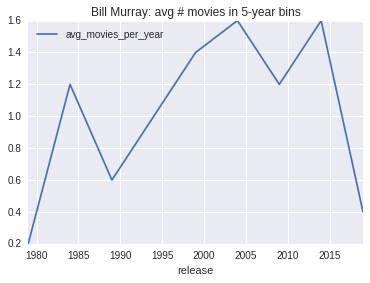

In [236]:
plot_actor_career('Bill Murray', 5)

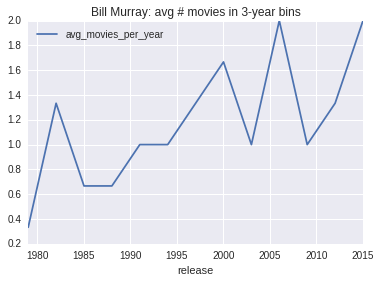

In [237]:
plot_actor_career('Bill Murray', 3)

In [254]:
# OK, need birthday info. I don't trust my filters, so I'm going to start again.

print actor_full.shape
print actor_revenue.shape

full_set = set(actor_full.actor.unique())
rev_set = set(actor_revenue.actor_name.unique())

print len(full_set), len(rev_set)

print full_set.issubset(rev_set) #True. All the actors in actor_full are contained in actor_revenue (da big one)
diff = rev_set.difference(full_set)
print len(diff), 'missing birthdays.'
diff
# These are the people that are missing in actor_full:

(9342, 355)
(16416, 9)
715 781
True
66 missing birthdays.


{'50 Cent',
 'Adam Scott',
 'Alex Kendrick',
 'Alex Ross Perry',
 'Alex Russell',
 'Ben Barnes',
 'Billy Burke',
 'Bow Wow',
 'Boyd Holbrook',
 'Brian Cox',
 'Carrie-Anne Moss',
 'Catherine Zeta-Jones',
 "Chris 'Ludacris' Bridges",
 'Chris Evans',
 'Chris Klein',
 "Chris O'Donnell",
 'Christopher Mintz-Plasse',
 'Common',
 'Daisy Ridley',
 'Daniel Day-Lewis',
 'David Wain',
 'Dustin Ingram',
 'Elizabeth Debicki',
 'Ellen Wong',
 'Famke Janssen',
 'Ian McDiarmid',
 'Ice Cube',
 "Jack O'Connell",
 'Jada Pinkett-Smith',
 "Jason O'Mara",
 'Jay Chandrasekhar',
 'Jeffrey Wright',
 'Jenna Dewan-Tatum',
 'Jim Jarmusch',
 'John Wayne',
 'Joseph Gordon-Levitt',
 'Joseph Schneider',
 'Josh Zuckerman',
 'Katharine Hepburn',
 'Keith Gordon',
 'Kenny Wormald',
 'Kodi Smit-McPhee',
 'Leigh Whannell',
 'Macon Blair',
 'Madonna',
 'Mary-Kate Olsen',
 'Mia Wasikowska',
 'Michelle Williams',
 'Mike Nichols',
 "Mo'Nique",
 'Naomie Harris',
 'Ne-Yo',
 'Patrick Wilson',
 'Peter Mayhew',
 'Prabhu Dheva',
 'R

In [294]:
# # restart from the pickle
# actor_revenue = pd.read_pickle('actor_revenue.pickle')
# actor_age_binned = actor_full[['movie','bday','actor']].merge(
#     actor_revenue, how='inner', left_on='actor', right_on='actor_name').drop(['actor_name','rank','actor_id'], axis=1)

# actor_age_binned['age'] = actor_age_binned.release - actor_age_binned.bday
# # actor_age_binned.groupby('actor').set_index('release')
# actor_age_binned.head()

,movie,bday,actor,title,studio,adjusted_gross,unadjusted_gross,release,age
0,(500) Days of Summer,1997-02-10,Chloe Moretz,Bolt,BV,138198600,114053579,2008-11-21,4302 days
1,(500) Days of Summer,1997-02-10,Chloe Moretz,The Equalizer,Sony,106439800,101530738,2014-09-26,6437 days
2,(500) Days of Summer,1997-02-10,Chloe Moretz,Big Momma's House 2,Fox,93197500,70165972,2006-01-27,3273 days
3,(500) Days of Summer,1997-02-10,Chloe Moretz,The Amityville Horror (2005),MGM,88538300,65233369,2005-04-15,2986 days
4,(500) Days of Summer,1997-02-10,Chloe Moretz,Dark Shadows,WB,85601700,79727149,2012-05-11,5569 days


## groupby.apply example: just prints the name.

Note that it runs the first call twice, it does it for performance reasons. So watch out for side effects!

In [300]:
# def say(x):
#     print type(x), x.shape, x.actor.iloc[0]
#     return x
# actor_age_binned.groupby('actor').apply(lambda x: say(x))

## Now for the real thing!

In [60]:
def apply_yearly_bin(actor_data, no_years_in_bins, time_column, avg_movies_colname='avg_movies_per_year'):
    """
    Sum together all the rows within yearly bins.
    Also, adds a column called 'avg_movies_per_year' to count how many rows were in each bin
    Written to by run in a groupby.apply call
    """
    # make a dummy column to add movie counts together. pre-divide
    actor_data[avg_movies_colname] = 1.0
    
    # remember birthday & gender
    bday = actor_data.bday.iloc[0]
    male = actor_data.male_txt.iloc[0]
    
    actor_data = actor_data.sort_values(time_column).set_index(time_column)

    # resample into N-year periods
    # fill in empty intermediate bins with zeroes
    actor_data = actor_data.resample('%iA'%no_years_in_bins, how='sum',).fillna(0).reset_index()
    
    actor_data['bday'] = bday
    actor_data['male'] = male

    # http://stackoverflow.com/questions/2217488/age-from-birthdate-in-python/9754466#9754466
    # calculate human-intuitive age from date "today"
    date_diff = lambda today: today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))
    
    actor_data['age'] = actor_data.release.apply(date_diff)

    # divide summed movies by number 
    actor_data[avg_movies_colname] = actor_data[avg_movies_colname] / (no_years_in_bins*1.0)
    
    return actor_data.set_index('release').drop('male_txt', axis=1)
    return actor_data

def transform_yearly_bin(x,y):
    print '!!!%s...'%x.name
    z = x.copy()
    z['foo'] = 0
    return z

###### NOTEBOOK VAR #####
BIN_SIZE_IN_YEARS = 5
#########################

# restart from the pickle
actor_revenue = pd.read_pickle('actor_revenue.pickle')
actor_full = pd.read_pickle('joint_df.pickle')
actor_age_PRE_binned = actor_full[['movie','bday','actor','male_txt']].merge(
    actor_revenue, how='inner', left_on=['actor','movie'], right_on=['actor_name','title']).drop(['actor_name','rank','actor_id'], axis=1)

# filter out movies released in the future... otherwise you get ages of 120+
# also filter out birthdays before 1920, they're mistakes (at least the 1875 one is)
actor_age_PRE_binned = actor_age_PRE_binned[
    (actor_age_PRE_binned.release.dt.year < 2015) & \
    (actor_age_PRE_binned.bday.dt.year > 1900)]

actor_age_PRE_binned.head()

,movie,bday,actor,male_txt,title,studio,adjusted_gross,unadjusted_gross,release
0,(500) Days of Summer,1997-02-10,Chloe Moretz,0,(500) Days of Summer,FoxS,37749800,32391374,2009-07-17
1,(500) Days of Summer,1962-04-02,Clark Gregg,1,(500) Days of Summer,FoxS,37749800,32391374,2009-07-17
2,(500) Days of Summer,1980-06-24,Minka Kelly,0,(500) Days of Summer,FoxS,37749800,32391374,2009-07-17
3,(500) Days of Summer,1980-01-17,Zooey Deschanel,0,(500) Days of Summer,FoxS,37749800,32391374,2009-07-17
5,102 Dalmatians,1947-03-19,Glenn Close,0,102 Dalmatians,BV,107144200,66957026,2000-11-22


In [61]:
actor_age_binned = actor_age_PRE_binned.groupby('actor').apply(
    apply_yearly_bin, time_column='release', no_years_in_bins=BIN_SIZE_IN_YEARS)

actor_age_binned.head()

adjusted_gross  unadjusted_gross  \
actor         release                                        
Aaron Eckhart 1997-12-31         5315700           2804473   
              2002-12-31       398984700         246046830   
              2007-12-31       256675200         186746817   
              2012-12-31       769157900         643605041   
              2017-12-31       125895800         118000930   

                          avg_movies_per_year       bday  male  age  
actor         release                                                
Aaron Eckhart 1997-12-31                  0.2 1968-03-12     1   29  
              2002-12-31                  1.0 1968-03-12     1   34  
              2007-12-31                  1.4 1968-03-12     1   39  
              2012-12-31                  0.8 1968-03-12     1   44  
              2017-12-31                  0.4 1968-03-12     1   49

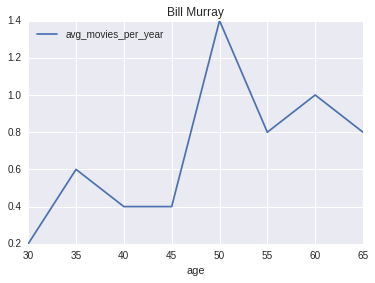

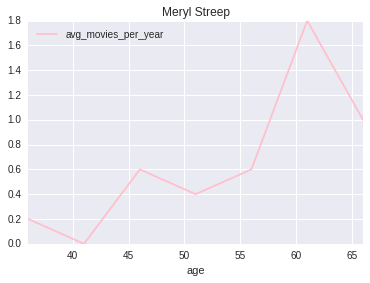

In [62]:
def plot_movies_by_age(actor_name, **kwargs):
    return actor_age_binned.loc[actor_name].plot('age','avg_movies_per_year', title=actor_name, **kwargs)

plot_movies_by_age('Bill Murray')
plot_movies_by_age('Meryl Streep', color='pink')

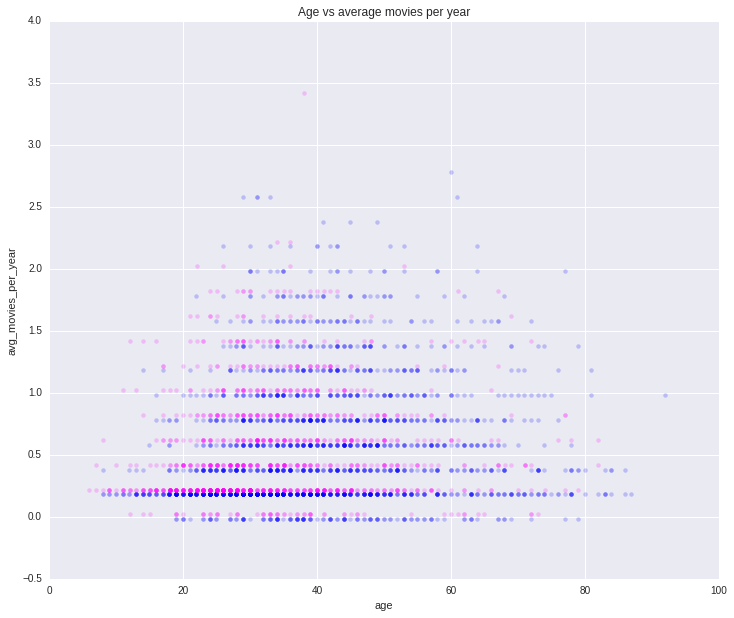

In [63]:
fig, ax = plt.subplots(figsize=(12,10))

offset=0.02
(actor_age_binned[actor_age_binned.male == 1]-offset).plot.scatter(
    'age','avg_movies_per_year', color=men_color, ax=ax, alpha=0.2, lw=0)
(actor_age_binned[actor_age_binned.male == 0]+offset).plot.scatter(
    'age','avg_movies_per_year', color=women_color, ax=ax, alpha=0.2, lw=0)

plt.title('Age vs average movies per year')

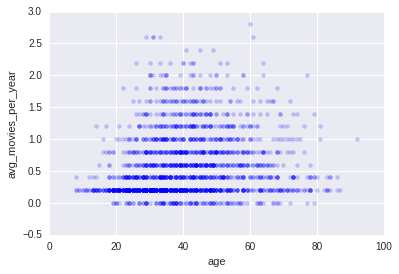

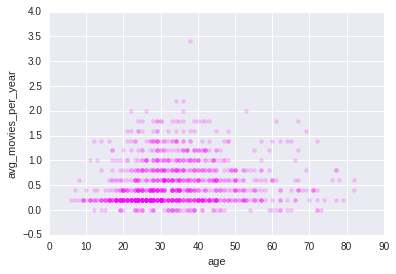

In [64]:
actor_age_binned[actor_age_binned.male == 1].plot.scatter(
    'age','avg_movies_per_year', color=men_color, alpha=0.2, lw=0)
# plt.xlim(0,100)
# plt.ylim(0,250)
actor_age_binned[actor_age_binned.male == 0].plot.scatter(
    'age','avg_movies_per_year', color=women_color, alpha=0.2, lw=0)
# plt.xlim(0,100)
# plt.ylim(0,250)

In [65]:
actor_age_binned[actor_age_binned.age > 80]

adjusted_gross  unadjusted_gross  \
actor               release                                        
Christopher Lee     2004-12-31       476753700         315544750   
                    2009-12-31       280217500         206459076   
                    2014-12-31       793831500         736542240   
Christopher Plummer 2010-12-31       512066700         427821601   
                    2015-12-31        38566900          34927520   
Clint Eastwood      2013-12-31        39258300          35763137   
Ian Holm            2014-12-31       329153300         303003568   
James Garner        2011-12-31         4348400           3438735   
Judi Dench          2016-12-31       419722600         388482297   
Leonard Nimoy       2014-12-31       622584500         581169204   
Leslie Nielsen      2010-12-31       128983800          97723811   
Maggie Smith        2016-12-31        70080000          64802158   
Michael Caine       2017-12-31       319617400         305744006   
Paul Newman         2009-12-31       324201800         244082982   
Robert Duvall       2012-12-31       295586700         256975015   
                    2017-12-31        49394700          47119388   

                                avg_movies_per_year       bday  male  age  
actor               release                                                
Christopher Lee     2004-12-31                  0.2 1922-05-27     1   82  
                    2009-12-31                  0.2 1922-05-27     1   87  
                    2014-12-31                  1.0 1922-05-27     1   92  
Christopher Plummer 2010-12-31                  1.2 1929-12-13     1   81  
                    2015-12-31                  0.4 1929-12-13     1   86  
Clint Eastwood      2013-12-31                  0.2 1930-05-31     1   83  
Ian Holm            2014-12-31                  0.2 1931-09-12     1   83  
James Garner        2011-12-31                  0.2 1928-04-07     1   83  
Judi Dench          2016-12-31                  0.6 1934-12-09     0   82  
Leonard Nimoy       2014-12-31                  0.4 1931-03-26     1   83  
Leslie Nielsen      2010-12-31                  0.4 1926-02-11     1   84  
Maggie Smith        2016-12-31                  0.4 1934-12-28     0   82  
Michael Caine       2017-12-31                  0.4 1933-03-14     1   84  
Paul Newman         2009-12-31                  0.2 1925-01-26     1   84  
Robert Duvall       2012-12-31                  1.0 1931-01-05     1   81  
                    2017-12-31                  0.2 1931-01-05     1   86

In [68]:
actor_age_binned[actor_age_binned.avg_movies_per_year > 3]

,,adjusted_gross,unadjusted_gross,avg_movies_per_year,bday,male,age
actor,release,,,,,,
Kristen Wiig,2011-12-31,1485340400,1297924944,3.4,1973-08-22,0,38
